In [12]:
#@title Imports
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from keras import *
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import *
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.losses import SparseCategoricalCrossentropy
from keras.optimizers import adam_v2

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer, LancasterStemmer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('wordnet')

from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, DataCollatorWithPadding, create_optimizer
from datasets import Dataset, DatasetDict

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [52]:
# load dataframe, delete article link column
pd.set_option('display.max_colwidth', None)
# there are v1 and v2
file_name = 'Sarcasm_Headlines_Dataset.json'
df = pd.read_json(file_name, lines=True)
del df['article_link']
df.head(5)

,headline,is_sarcastic
0,former versace store clerk sues over secret 'black code' for minority shoppers,0
1,"the 'roseanne' revival catches up to our thorny political mood, for better and worse",0
2,mom starting to fear son's web series closest thing she will have to grandchild,1
3,"boehner just wants wife to listen, not come up with alternative debt-reduction ideas",1
4,j.k. rowling wishes snape happy birthday in the most magical way,0


In [9]:
model_name = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Preprocessing

## Data cleaning

In [53]:
appos = {
        "aren't": "are not", "can't": "cannot", "couldn't": "could not", "didn't": "did not", "doesn't": "does not", "don't": "do not",
        "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he had", "he'll": "he will", "he's": "he is",
        "I'd": "I had", "I'll": "I will", "I'm": "I am", "I've": "I have", "isn't": "is not", "let's": "let us", "mightn't": "might not",
        "mustn't": "must not", "shan't": "shall not", "she'd": "she had", "she'll": "she will", "she's": "she is", "shouldn't": "should not",
        "what's": "what is", "there's": "there is", "they'd": "they had", "they'll": "they will", "they've": "they have",
        "we'd": "we had", "we're": "we are", "we've": "we have", "weren't": "were not",
}
def transform_appos(headline):
    arr = []
    for row in headline.values:
        for word in row:
            if word in appos.keys():
                row = row.replace(word, appos[word])
    return headline

def to_lowercase(headline):
    headline = headline.apply(lambda x: x.lower())
    return headline

def remove_whitespaces(headline):
    headline = headline.str.strip()
    return headline

def replace_quote(headline):
    headline = headline.str.replace("’", "'")
    return headline


# new
def remove_stop_words(headline):
  stop = stopwords.words('english')
  headline = headline.apply(lambda x: [item for item in x.split() if item not in stop])
  headline = headline.apply(lambda x: ' '.join(map(str, x)))
  return headline

def remove_numbers(headline):
   headline = headline.str.replace('\d+', '')
   return headline

def remove_punctuation(headline):
  headline = headline.str.replace('[^\w\s]','')
  return headline

def apply_lemmatization(headline):
   lemmatizer = WordNetLemmatizer()
   headline = headline.apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))
   return headline

def preprocess(headlines: pd.Series):
    headlines = to_lowercase(headlines)
    headlines = replace_quote(headlines)
    headlines = transform_appos(headlines)
    headlines = remove_stop_words(headlines)
    headlines = remove_numbers(headlines)
    headlines = remove_punctuation(headlines)
    headlines = apply_lemmatization(headlines)
    return headlines


In [54]:
# apply preprocessing to the whole dataset
df['headline'] = preprocess(df['headline'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: FutureWarning: The default value of regex will change from True to False in a future version.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: FutureWarning: The default value of regex will change from True to False in a future version.


In [55]:
df['headline']

0        former versace store clerk sue secret black code minority shopper
1                roseanne revival catch thorny political mood better worse
2                mom starting fear son web series closest thing grandchild
3             boehner want wife listen come alternative debtreduction idea
4                         jk rowling wish snape happy birthday magical way
                                       ...                                
26704                                     american politics moral freefall
26705                                                    america best hike
26706                                                     reparation obama
26707           israeli ban targeting boycott supporter raise alarm abroad
26708                                                  gourmet gift foodie
Name: headline, Length: 26709, dtype: object

## Preprocessing for huggingface

In [56]:
def create_datasets_from_dataframe(df: pd.DataFrame):
    # split data into train and test set into 60:20:20
    train_df, test_df = train_test_split(df, train_size=0.6, shuffle=True, random_state=0)
    val_df, test_df = train_test_split(test_df, train_size=0.5, shuffle=True, random_state=0)

    # create dataset objects 
    train_dataset = Dataset.from_pandas(train_df)
    val_dataset = Dataset.from_pandas(val_df)
    test_dataset = Dataset.from_pandas(test_df)

    # create dataset dict with dataset objects
    datasets = DatasetDict()
    datasets['train'] = train_dataset
    datasets['val'] = val_dataset
    datasets['test'] = test_dataset
    return datasets

datasets = create_datasets_from_dataframe(df)

In [57]:
# first sentence
print(datasets['train'][0])
print(tokenizer(datasets['train'][0]['headline']))

{'headline': 'bernice king say trump racist comment troubling humanity', 'is_sarcastic': 0, '__index_level_0__': 17847}
{'input_ids': [101, 16595, 6610, 2332, 2360, 8398, 16939, 7615, 19817, 7140, 9709, 8438, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [58]:
# tokenize and dynamic padding with collator
def tokenize_function(item):
    return tokenizer(item['headline'],
                     padding=True,
                     truncation=True,
                     max_length=128)

tokenized_datasets = datasets.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

  0%|          | 0/17 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

In [59]:
def convert_dataset_to_tf_dataset(dataset: Dataset):
    tf_dataset = dataset.to_tf_dataset(
        columns=["attention_mask", "input_ids", "token_type_ids"],
        label_cols=["is_sarcastic"],
        shuffle=False,
        collate_fn=data_collator,
        batch_size=64,
    )
    return tf_dataset

tf_train_dataset = convert_dataset_to_tf_dataset(tokenized_datasets['train'])
tf_val_dataset = convert_dataset_to_tf_dataset(tokenized_datasets['val'])
tf_test_dataset = convert_dataset_to_tf_dataset(tokenized_datasets['test'])

# Create and train model

In [60]:
num_of_epochs = 6

# callbacks
stop_early = EarlyStopping(monitor='val_loss', patience=3)

# no need to save best weights, huggingface is already saving the best weights when save_pretrained() is called
save_best_weights = ModelCheckpoint('checkpoints/bert', 
                                              monitor='val_loss',
                                              save_best_only=True,
                                              save_weights_only=True)

In [61]:
def model_builder():
    model = TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
    
    num_train_steps = len(tf_train_dataset) * num_of_epochs
    # warmup proportion is 0.1 -> https://arxiv.org/pdf/1905.05583.pdf
    num_warmup_steps = num_train_steps // 10 

    optimizer, _ = create_optimizer(init_lr=2e-5,
                                    num_train_steps= num_train_steps,
                                    num_warmup_steps=num_warmup_steps,
                                    min_lr_ratio=0)

    model.compile(optimizer, SparseCategoricalCrossentropy(from_logits=True), ['acc'])
    return model

In [62]:
model = model_builder()
history = model.fit(tf_train_dataset,
          validation_data=tf_val_dataset,
          epochs=num_of_epochs,
          callbacks=[stop_early, save_best_weights])

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/6
251/251 [==============================] - 213s 748ms/step - loss: 0.5502 - acc: 0.7093 - val_loss: 0.4020 - val_acc: 0.8137
Epoch 2/6
251/251 [==============================] - 185s 736ms/step - loss: 0.3274 - acc: 0.8637 - val_loss: 0.3737 - val_acc: 0.8411
Epoch 3/6
251/251 [==============================] - 179s 712ms/step - loss: 0.2069 - acc: 0.9188 - val_loss: 0.4137 - val_acc: 0.8497
Epoch 4/6
251/251 [==============================] - 179s 712ms/step - loss: 0.1205 - acc: 0.9583 - val_loss: 0.4655 - val_acc: 0.8544
Epoch 5/6
251/251 [==============================] - 179s 711ms/step - loss: 0.0784 - acc: 0.9747 - val_loss: 0.5278 - val_acc: 0.8474


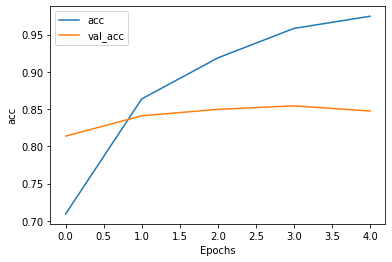

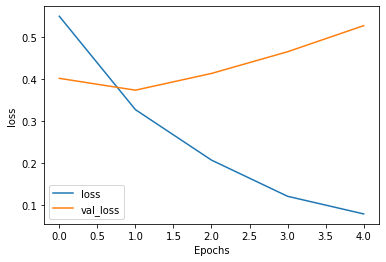

In [63]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_' + string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_' + string])
  plt.show()
  
plot_graphs(history, "acc")
plot_graphs(history, "loss")

In [64]:
model.config.id2label = {0: 'not_sarcastic', 1: 'is_sarcastic'}
model.save_pretrained('my-model')
tokenizer.save_pretrained('my-tokenizer')
my_model = TFAutoModelForSequenceClassification.from_pretrained('my-model')
my_model.compile(loss=SparseCategoricalCrossentropy(from_logits=True),metrics=['acc'])

Some layers from the model checkpoint at my-model were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at my-model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [65]:
loss, acc = my_model.evaluate(tf_test_dataset)

84/84 [==============================] - 25s 220ms/step - loss: 0.5497 - acc: 0.8420


In [66]:
predictions = my_model.predict(tf_test_dataset)
y_pred = np.argmax(predictions['logits'], axis=1)
y_true = np.concatenate([y for x, y in tf_test_dataset], axis=0)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.94      0.87      3014
           1       0.90      0.72      0.80      2328

    accuracy                           0.84      5342
   macro avg       0.85      0.83      0.83      5342
weighted avg       0.85      0.84      0.84      5342



In [67]:
# predictions
raw_inputs = ["It's a beautiful day.",
              "It’s okay if you don’t like me not everyone has good taste."]
my_tokenizer = AutoTokenizer.from_pretrained('my-tokenizer')
inputs = my_tokenizer(text=raw_inputs, padding=True, truncation=True, return_tensors='tf')
outputs = my_model(inputs)

predictions = tf.math.softmax(outputs.logits)

for pred in predictions:
    print(f'{my_model.config.id2label[0]}: {pred[0]}')
    print(f'{my_model.config.id2label[1]}: {pred[1]}')
    print('------')

not_sarcastic: 0.9980820417404175
is_sarcastic: 0.001917951856739819
------
not_sarcastic: 0.9947468638420105
is_sarcastic: 0.0052531627006828785
------
